In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


This example is for a particular business relying heavily on online sales. It can run very accurate calculations to figure out what is the optimal placement of their product across warehouses. Unfortunately, the calculations are extremely expensive (computationally) to run, so they can only do it once every two weeks. Instead, they propose using a machine learning model which approximates the solution quickly (in a few hours). The model has four hyper-parameters you need to tune, and the output corresponds to the difference between the expensive calculation, and the model. Since you are modelling a dynamical system, expect a lot of local optima!

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_4/initial_inputs.npy',
    '../initial_data/function_4/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_4/initial_inputs.npy',
    '../initial_data2/function_4/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,x3,x4,y
0,0.896981,0.725628,0.175404,0.701694,-22.108288
1,0.889356,0.499588,0.539269,0.508783,-14.601397
2,0.250946,0.033693,0.145380,0.494932,-11.699932
3,0.346962,0.006250,0.760564,0.613024,-16.053765
4,0.124871,0.129770,0.384400,0.287076,-10.069633


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f4', 'f4_output']]
df_feedback['f4'] = df_feedback['f4'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f4'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f4'].apply(lambda x: float(x[i]))

df_feedback.drop('f4', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f4_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'x4', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,x3,x4,y
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.528460,0.515663,0.507661,0.518004,-19.934925
std,0.314248,0.328446,0.308667,0.292946,10.534476
min,0.027731,0.002479,0.005458,0.021964,-54.085739
25%,0.236912,0.163308,0.227297,0.270500,-25.888151
50%,0.523331,0.572710,0.482864,0.526994,-16.679115
75%,0.841576,0.801140,0.748264,0.773136,-13.494957
max,0.999999,0.999999,0.999999,0.999483,-4.025542


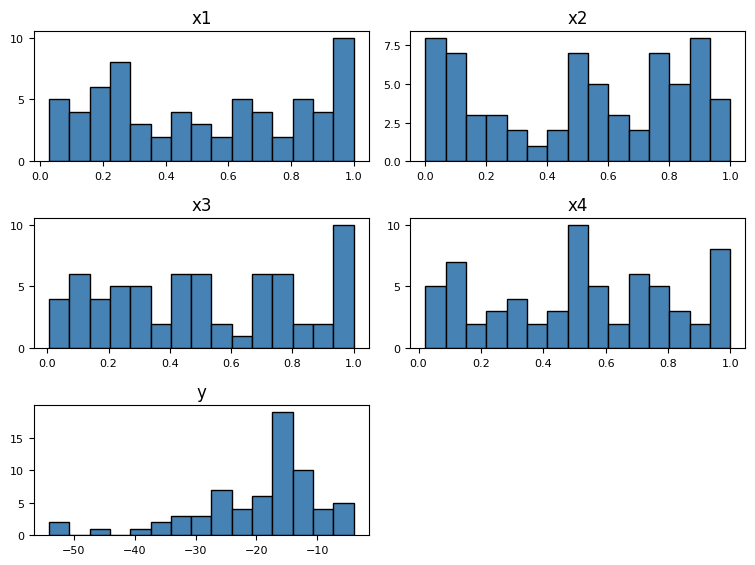

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


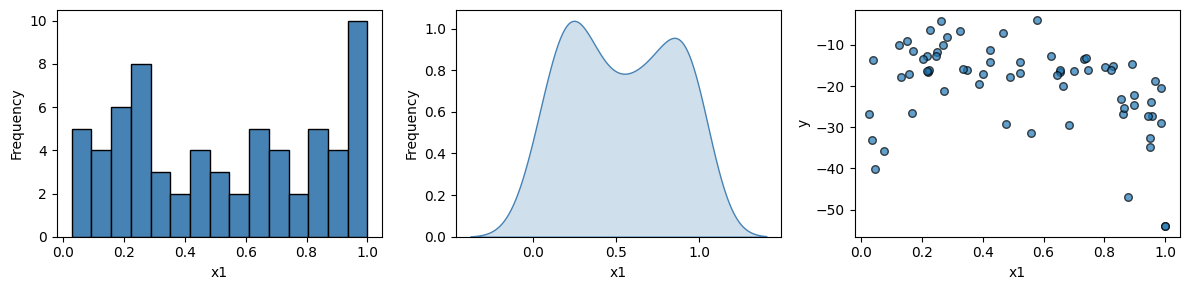

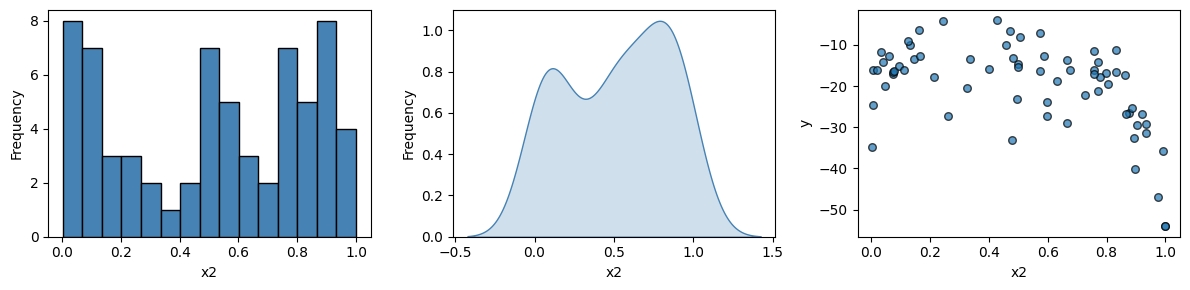

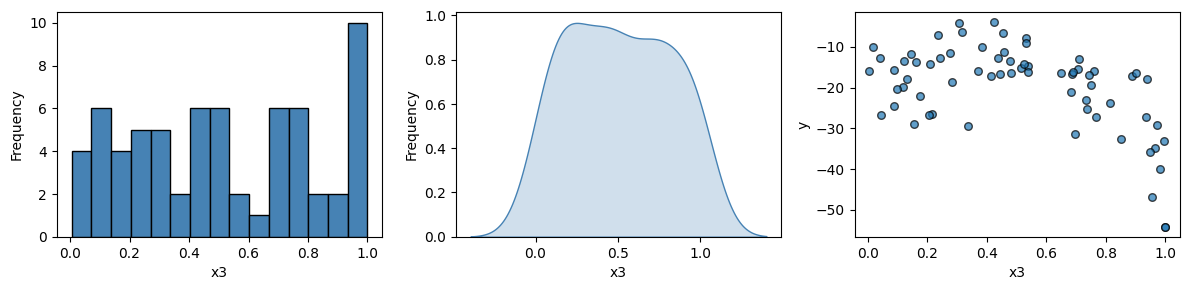

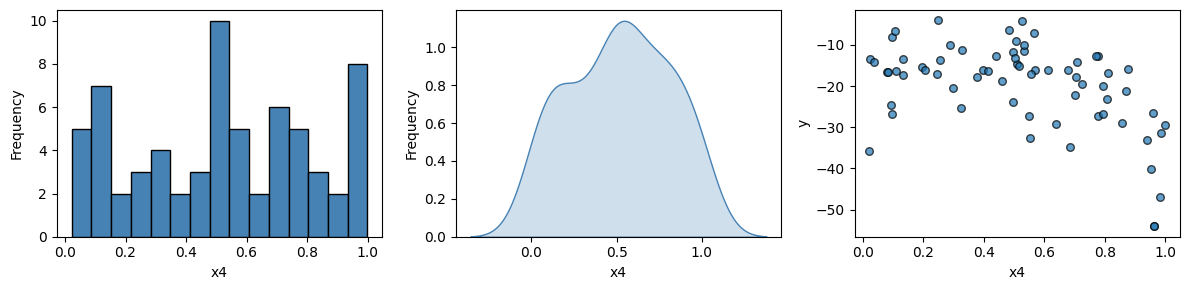

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')
analyse_param(df, 'x4', 'y')

In [20]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3", "x4"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

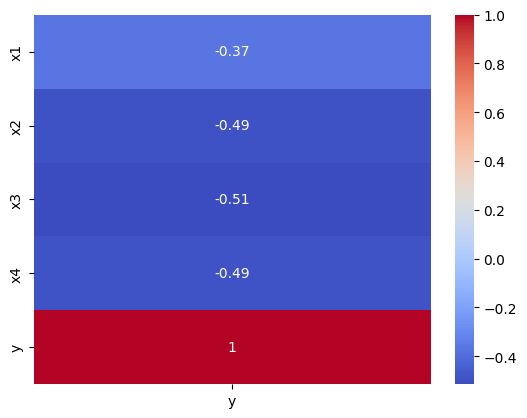

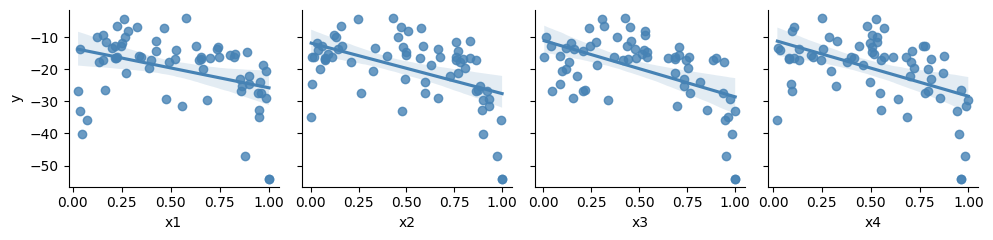

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

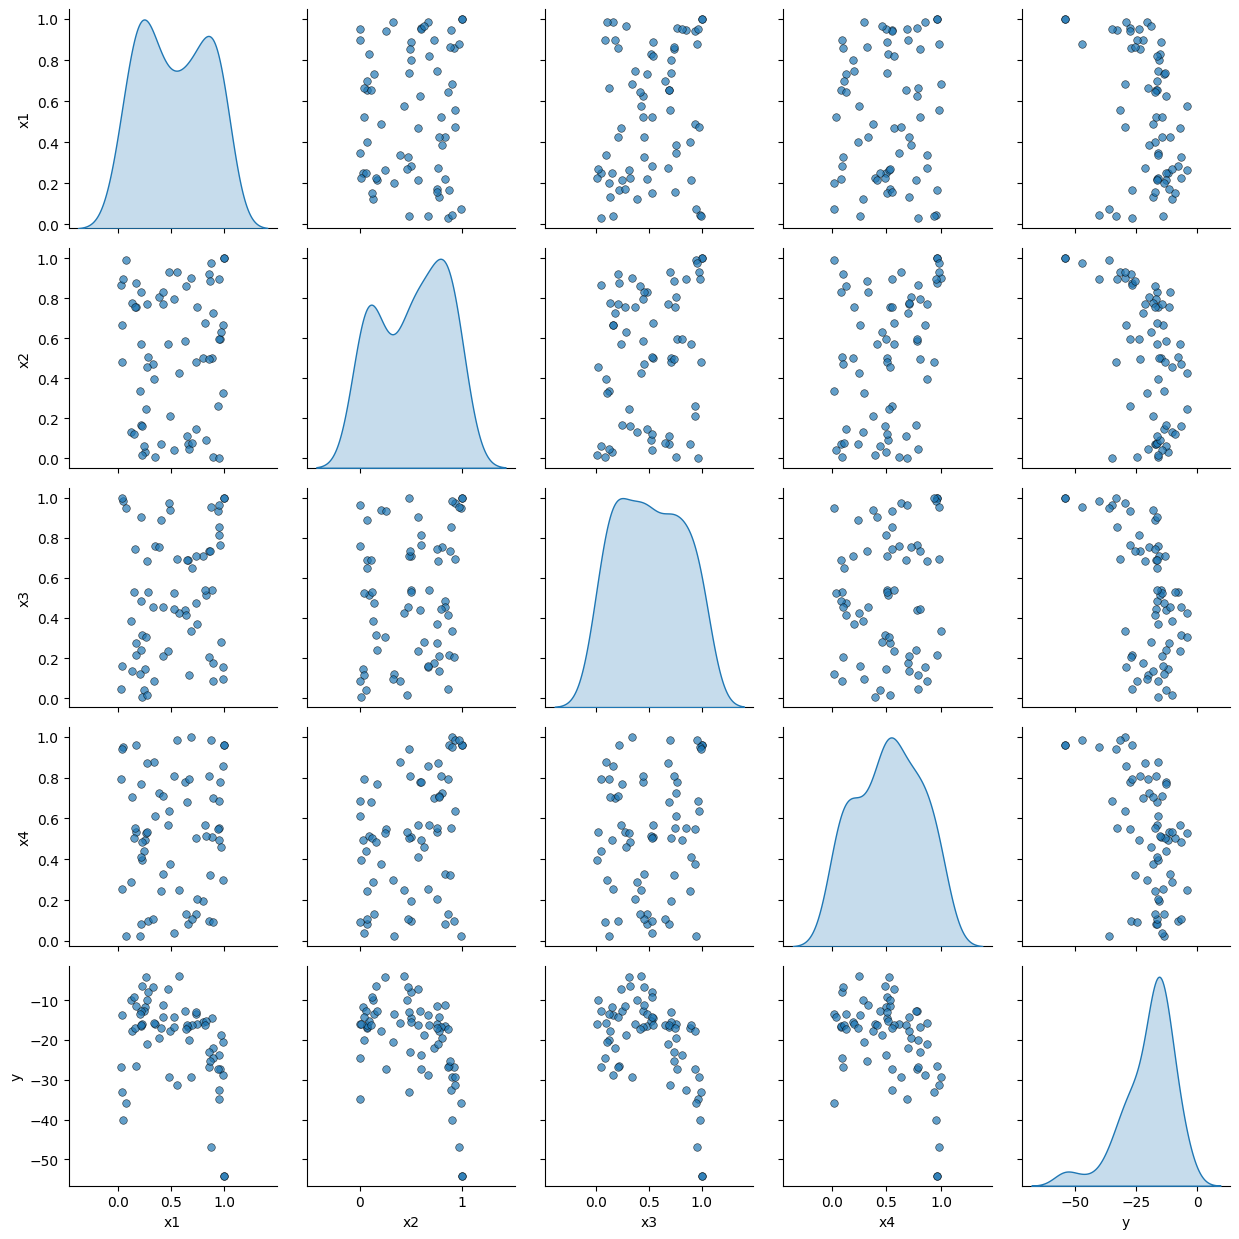

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return np.abs([x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3]])

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x4', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.RBF(
    input_dim=4,
    variance=1.0,
    lengthscale=1.0
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 15)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer, jitter=0.01)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3', 'x4']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [25]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
